In [1]:
import torch

from refiners.fluxion.utils import load_from_safetensors, manual_seed, no_grad, images_to_tensor, tensor_to_image
from refiners.foundationals.latent_diffusion.lora import SDLoraManager
from refiners.foundationals.latent_diffusion.stable_diffusion_xl import (
    StableDiffusion_XL,
)

from layerdiffuse.models.models import TransparentVAEDecoder
from utils.utils import load_frozen_patcher

from PIL import Image

torch.autocast("cuda", torch.float16).__enter__()

In [ ]:
#Load SDXL
sdxl = StableDiffusion_XL(device="cuda", dtype=torch.float16)
sdxl.clip_text_encoder.load_from_safetensors("/home/chloe/test/layerdiffuse/juggernaut-xl/text_encoder.safetensors")
sdxl.unet.load_from_safetensors("/home/chloe/test/layerdiffuse/juggernaut-xl/unet.safetensors")
sdxl.lda.load_from_safetensors("/home/chloe/test/layerdiffuse/juggernaut-xl/lda.safetensors")

In [20]:
#Load LoRA weights from disk and inject them into target
manager = SDLoraManager(sdxl)

ld_lora_weights = load_from_safetensors("/home/chloe/test/layerdiffuse/layer_xl_transparent_attn.safetensors")
ld_lora_weights_modified = load_frozen_patcher(ld_lora_weights)

#sci_fi_lora_weights = load_from_safetensors("sci-fi-lora.safetensors")

manager.add_loras("ld-lora", tensors=ld_lora_weights_modified, unet_inclusions= ["Attention", "SelfAttention"])


In [21]:
# Load Layer diffuse decoder
ld_decoder = TransparentVAEDecoder("/home/chloe/test/layerdiffuse/vae_transparent_decoder.safetensors")

In [28]:
# Hyperparameters
#prompt = "a futuristic magical panda with a purple glow, cyberpunk"
prompt = "portrait of a futuristic stylized panda mage, holding a crystal ball in his hands,purple glow, cyberpunk, animation"
seed = 1234
sdxl.set_inference_steps(50, first_step=0)
sdxl.set_self_attention_guidance(
    enable=True, scale=0.7
)  # Enable self-attention guidance to enhance the quality of the generated images


Step 0
Step 10
Step 20
Step 30
Step 40


100%|██████████| 8/8 [00:01<00:00,  4.27it/s]


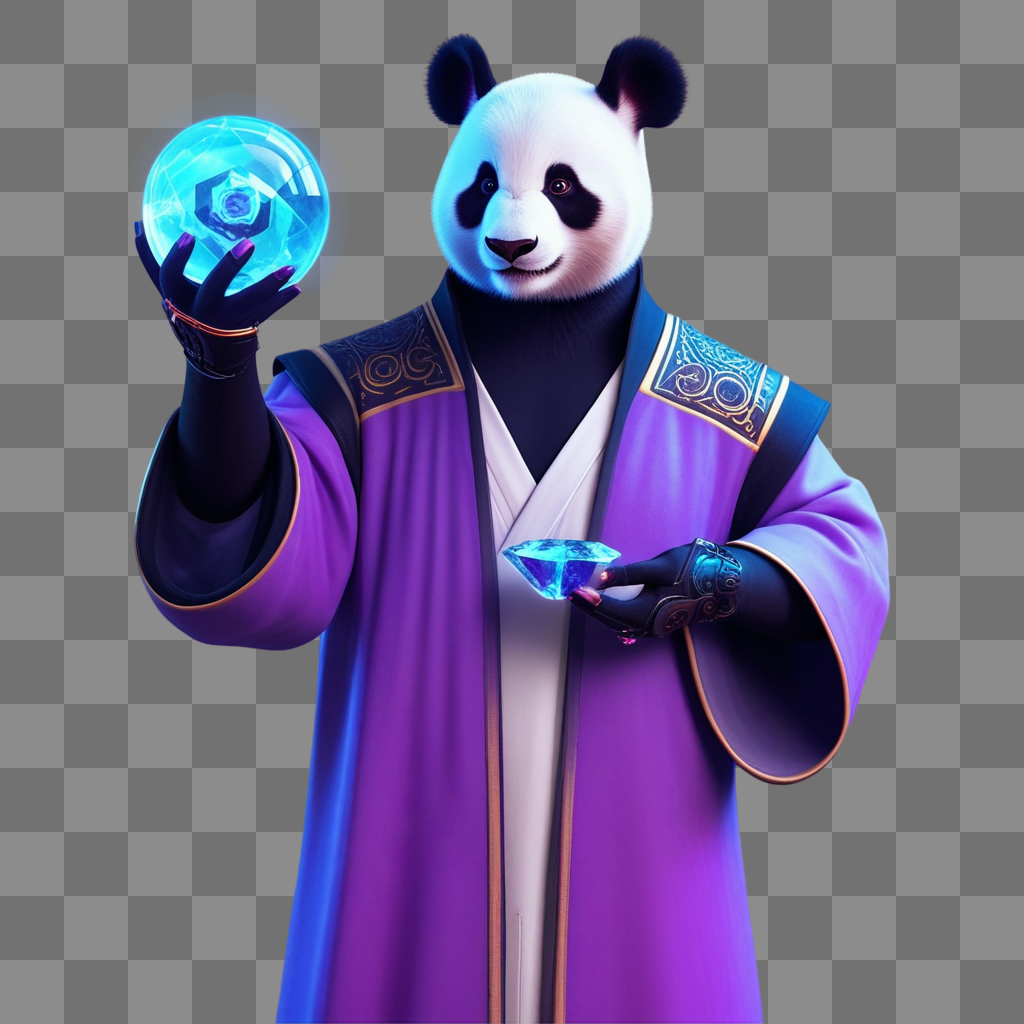

In [29]:
with no_grad():
    clip_text_embedding, pooled_text_embedding = sdxl.compute_clip_text_embedding(
        text=prompt + ", best quality, high quality",
        negative_text="monochrome, lowres, bad anatomy, worst quality, low quality",
    )
    time_ids = sdxl.default_time_ids

    manual_seed(seed=seed)

    
    x = sdxl.init_latents((1024, 1024)).to(sdxl.device, sdxl.dtype)

    # Diffusion process
    for step in sdxl.steps:
        if step % 10 == 0:
            print(f"Step {step}")
        x = sdxl(
            x,
            step=step,
            clip_text_embedding=clip_text_embedding,
            pooled_text_embedding=pooled_text_embedding,
            time_ids=time_ids,
        )
    latent = x
    pixel = sdxl.lda.decode_latents(x)
    #pixel.save("outputs/origin_sdxl.png")
    pixel = images_to_tensor([pixel], dtype = torch.float16, device= "cuda")
    transparent_image, transparent_image_png = ld_decoder.run(pixel, latent)

#tensor_to_image(transparent_image).save("/home/chloe/test/layerdiffuse/outputs/transparent_sdxl.png")
output = tensor_to_image(transparent_image)
#output = Image.fromarray(transparent_image_png)
#output.save("/home/chloe/test/layerdiffuse/outputs/transparent_sdxl_usable.png")
output